In [1]:
# AlexNet
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
net = nn.Sequential(
    nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU()
    ,nn.MaxPool2d(kernel_size=3,stride=2)
    ,nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU()
    ,nn.MaxPool2d(kernel_size=3,stride=2)
    # 连续三个卷积层
    ,nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU()
    ,nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU()
    ,nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU()
    ,nn.MaxPool2d(kernel_size=3,stride=2)
    ,nn.Flatten()
    # 进入全连接层
    ,nn.Linear(6400,4096),nn.ReLU()
    ,nn.Dropout(p=0.5) # 训练时随机丢弃一半
    ,nn.Linear(4096,4096),nn.ReLU()
    ,nn.Dropout(p=0.5)
    ,nn.Linear(4096,10)
)

In [7]:
X = torch.randn(1,1,224,224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [8]:
batch_size = 128
d2l.accuracy
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.328, train acc 0.880, test acc 0.885
581.6 examples/sec on cuda:0


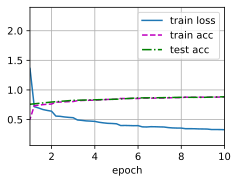

In [9]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

----
# VGG 

In [15]:

# 实现一个vgg块，一个块应该有若干个卷积层，一个卷积层内核都是3*3，padding 1 也就是输出特征图大小不变
def vgg_block(num_convs,in_channels,out_channels):
    layers = []
    for _ in range(num_convs):
        # 添加一个卷积层
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    # 最后添加池化
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [16]:
# 定义vgg网络，由若干个块租成
# 先定义每个vgg块的卷积层数量和通道的配置
# （vgg块内的卷积层数，输出通道数量）
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [17]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [19]:
ratio = 4
# 等比例缩小vgg配置，不然训练过久
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
print(small_conv_arch)
net = vgg(small_conv_arch)

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]


loss 0.179, train acc 0.933, test acc 0.922
28.3 examples/sec on cuda:0


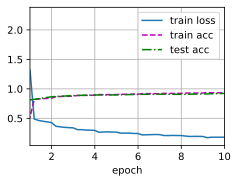

In [20]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())